<a href="https://colab.research.google.com/github/pinakm9/sphere-fp/blob/master/data/2D/sphere2D.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import required modules**

In [1]:
# run this cell to download data and necessary modules
import os, shutil
repo = 'sphere-fp'
if os.path.isdir(repo):
  shutil.rmtree(repo)
!git clone https://github.com/pinakm9/sphere-fp.git
# add modules folder to Python's search path
import sys
sys.path.insert(0, repo + '/modules')
# import the necessary modules
import numpy as np
import tensorflow as tf
import lss_solver as lss
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

Cloning into 'sphere-fp'...
remote: Enumerating objects: 182, done.
remote: Counting objects: 100% (61/61), done.
remote: Compressing objects: 100% (52/52), done.
remote: Total 182 (delta 14), reused 43 (delta 9), pack-reused 121
Receiving objects: 100% (182/182), 49.86 MiB | 27.17 MiB/s, done.
Resolving deltas: 100% (48/48), done.


**Define the equation through the $\mathcal L_{\log}$ operator**

In [2]:
DTYPE = tf.float32
D = 1.0
dim = 2
ones = np.ones(dim)
domain = [-3. * ones, 3. * ones]
save_folder = '{}/data/2D'.format(repo)

@tf.function
def diff_log_op(f, x, y):
    z = 4.*(x**2 + y**2 - 1.)
    with tf.GradientTape(persistent=True) as tape:
        tape.watch([x, y])
        f_ = f(x, y)
        f_x, f_y = tape.gradient(f_, [x, y])
    f_xx = tape.gradient(f_x, x)
    f_yy = tape.gradient(f_y, y)
    return z*(x*f_x + y*f_y) + 4.*(z+2.) + D*(f_x**2 + f_y**2 + f_xx + f_yy) 

**Define the steady state $p_\infty(\mathbf x)$**

In [3]:
from scipy.special import erf
import numpy as np

def p_inf(x, y):
  Z = 0.5 * np.sqrt(np.pi**3 * D) * (1. + erf(1/np.sqrt(D)))
  return tf.exp(-(x**2 + y**2 - 1.)**2 / D) / Z

**Set up experiment parameters and learn the stationary distribution**

In [4]:
learning_rate = tf.keras.optimizers.schedules.PiecewiseConstantDecay([1000, 2000, 10000], [5e-3, 1e-3, 5e-4, 1e-4])
optimizer = tf.keras.optimizers.Adam(learning_rate)
solver = lss.LogSteadyStateSolver(num_nodes=50, num_blocks=3, dtype=DTYPE, name='sphere{}D'.format(dim), diff_log_op=diff_log_op, optimizer=optimizer, domain=domain)
solver.learn(epochs = 800000, n_sample = 1000, save_folder=save_folder)

Streaming output truncated to the last 5000 lines.
750000    0.000271        13351.7884
750010    0.000271        13351.9627
750020    0.000283        13352.1344
750030    0.000285        13352.3057
750040    0.001529        13352.4817
750050    0.001211        13352.6634
750060    0.000776        13352.8579
750070    0.000494        13353.0280
750080    0.000761        13353.1972
750090    0.000362        13353.3663
750100    0.000328        13353.5363
750110    0.000311        13353.7075
750120    0.000291        13353.8839
750130    0.000281        13354.0551
750140    0.000270        13354.2282
750150    0.000289        13354.4025
750160    0.000299        13354.5747
750170    0.000269        13354.7522
750180    0.000293        13354.9322
750190    0.000263        13355.1095
750200    0.000278        13355.2860
750210    0.011616        13355.4582
750220    0.001949        13355.6309
750230    0.000863        13355.8044
750240    0.000497        13355.9747
750250    0.000345      

**Visualize the learned distribution**

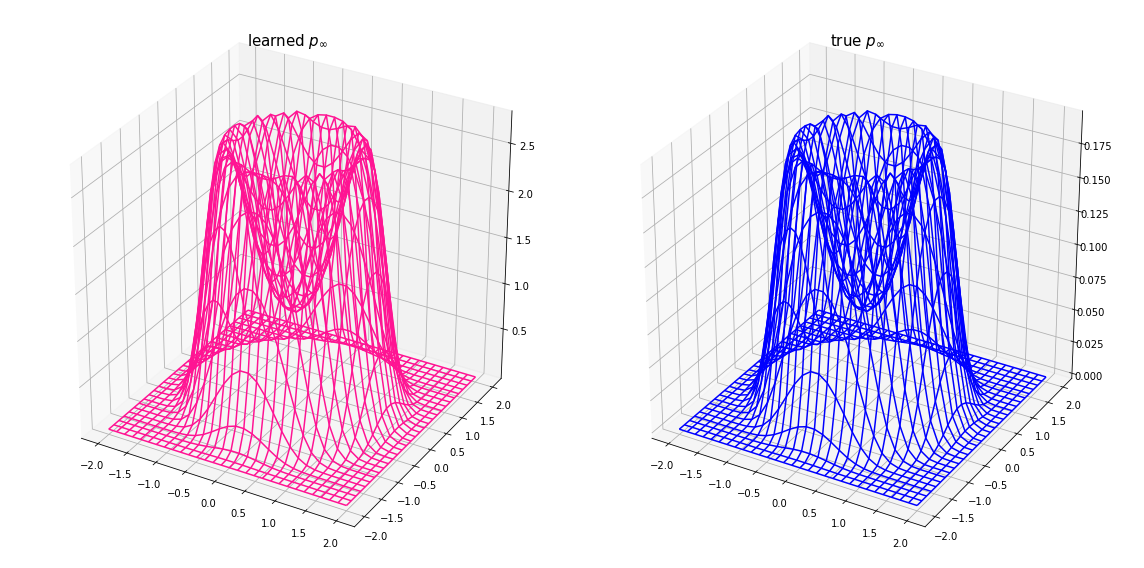

In [5]:
import matplotlib.pyplot as plt

def plot_solutions(learned, true, resolution=30, low=[-2., -2], high=[2., 2.]):
  fig = plt.figure(figsize=(16, 8))
  ax_l = fig.add_subplot(121, projection='3d')
  ax_t = fig.add_subplot(122, projection='3d')
  x = np.linspace(low[0], high[0], num=resolution, endpoint=True)
  y = np.linspace(low[1], high[1], num=resolution, endpoint=True)
  y = np.repeat(y, resolution, axis=0).reshape((-1, 1))
  x = np.array(list(x) * resolution).reshape((-1, 1))
  z_l = learned(x, y).numpy()
  z_t = true(x, y).numpy()
  grid = (resolution, resolution)
  x = x.reshape(grid)
  y = y.reshape(grid)
  z_l = z_l.reshape(grid)
  z_t = z_t.reshape(grid)
  ax_l.plot_wireframe(x, y, z_l, color='deeppink')
  ax_l.set_title('learned $p_\infty$', fontsize=15)
  ax_t.plot_wireframe(x, y, z_t, color='blue')
  ax_t.set_title('true $p_\infty$', fontsize=15)
  plt.tight_layout()
  plt.show()
  

plot_solutions(learned=lambda *args: tf.exp(solver.net(*args)), true=p_inf)

**Visulaize the noramlized learned solution**

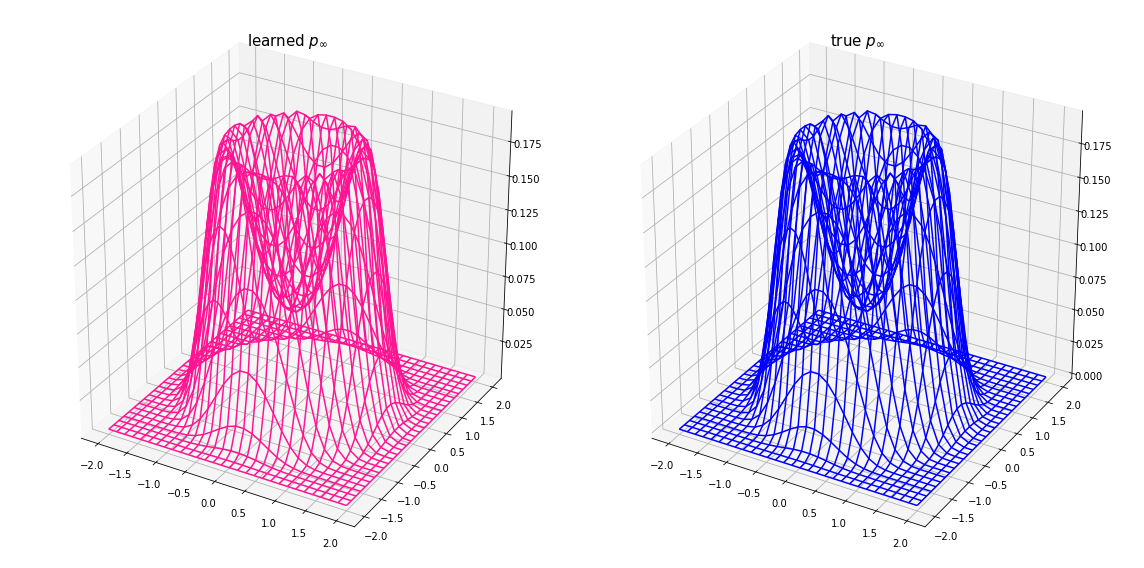

In [6]:
x, y = solver.sampler(n_sample=100000, domain=[-3. * ones, 3. * ones])
Z_mc = 6**2 * tf.reduce_mean(tf.exp(solver.net(x, y))).numpy()
plot_solutions(learned=lambda *args: tf.exp(solver.net(*args)) / Z_mc, true=p_inf)

**Investigate the size of $θ$**

In [7]:
solver.net.summary()

Model: "sphere2D"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 LSTMForgetBlock (LSTMForget  multiple                 1000      
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 10600     
 Block)                                                          
                                                                 
 LSTMForgetBlock (LSTMForget  multiple                 10600     
 Block)                                                          
                                                                 
 dense (Dense)               multiple                  51        
                                                                 
 batch_normalization (BatchN  multiple                 0 (unused)
 ormalization)                                            